1. Camera Calibration
2. Undistort
3. Sobel Gradient
4. Perspective Transform
5. Lane Search

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

## 1. Camera Calibration

Procedure
* asdasd

Results
* asd

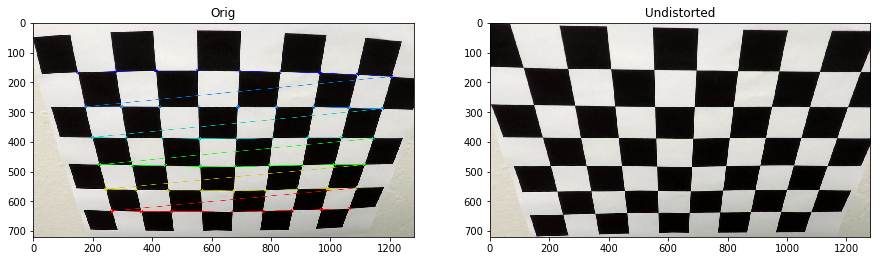

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) # the z-coordinate is set at zero
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # List of pairs coordinates (x, y on the chessboard)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')
plt.figure(figsize=(15,15))
# Step through the list and search for chessboard corners
for idx, fname in enumerate(calib_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    if idx == 5:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(121, title='Orig')
        plt.imshow(img)
        
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
        
calibration_pickle = {}
calibration_pickle["mtx"] = mtx
calibration_pickle["dist"] = dist
pickle.dump(calibration_pickle, open("camera_cal/wide_calib_pickle.p", "wb" ))

plt.subplot(122, title='Undistorted')
plt.imshow(cv2.undistort(mpimg.imread('camera_cal/calibration2.jpg'), mtx, dist, None, mtx))

## 2. Pipeline

Helper Functions

In [7]:
def undistort(img, mtx, dist):
    return cv2.undistort(test_img, mtx, dist, None, mtx)

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    scaled_sobel = np.uint8(255*np.absolute(sobel)/np.max(np.absolute(sobel)))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    scaled_sobel = np.uint8(255*direction/np.max(direction))
    dir_binary = np.zeros_like(scaled_sobel)
    dir_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(layer, thresh=(0, 255)):
    if np.max(layer) > 175:
        layer = layer*(255/np.max(layer))
    color_binary = np.zeros_like(layer)
    color_binary[(layer >= thresh[0]) & (layer <= thresh[1])] = 1
    return color_binary

def perspective_transform(img, mtx, dist, corners, dst_corners=None):
    y, x, _ = img.shape
    src = np.float32(corners)
    # Get the destination coordinates
    if dst_corners:
        dst = np.float32(dst_corners)
    else:
        offset = 0
        dst = np.float32([[450, offset], [x-450, offset], [450, y], [x-450, y]])
    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(img, M, (x,y))
    # Need this to reverse the bird eye-view after drawing the lanes
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    return transformed, M_inverse

def get_vertices(img, bottom_width = 0.85, top_width = 0.07, height_prop = 0.4):
    """
    Return vertices that define the polygon where the lanes are. 
    Top and bottom edges of trapezoid are expressed as percentage of image width.
    Height of the trapezoid expressed as percentage of image height.
    Measurements are suggested by @georgesung
    """
    imshape = img.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height_prop),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height_prop),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0])]], dtype=np.int32)
    return vertices

def region_of_interest(img, vertices):
    """
    Given a set of polygon vertices, apply an image mask, keep the region of the image defined by the polygon
    The rest of the image is set to black.
    """
    # Define a black mask
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels (inside the ROI) are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

Let's try to undistort all test images. Obviously, we can see the car hood is changed.

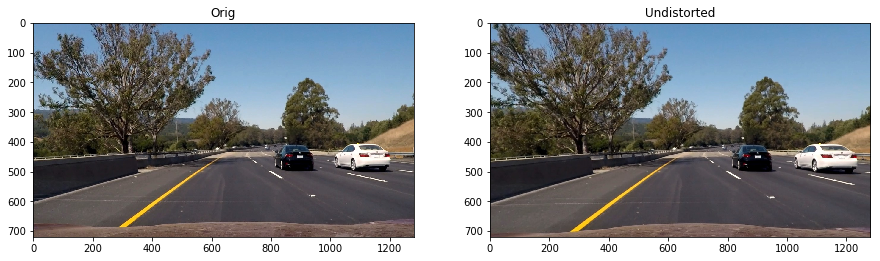

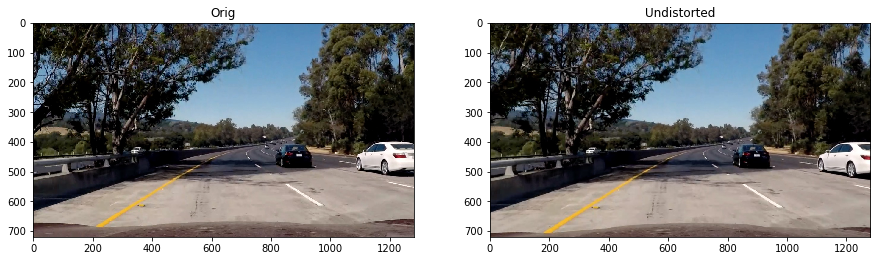

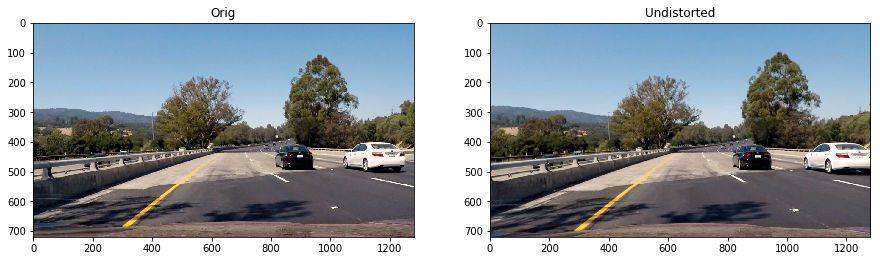

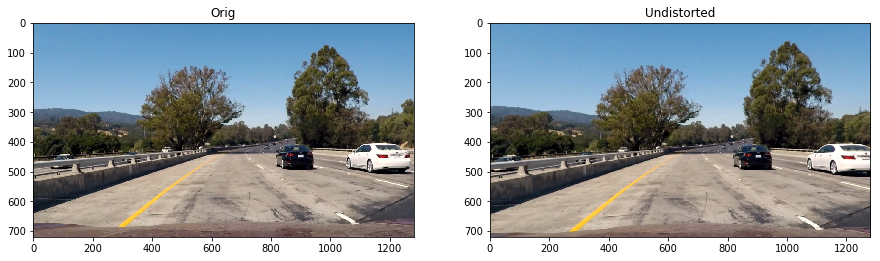

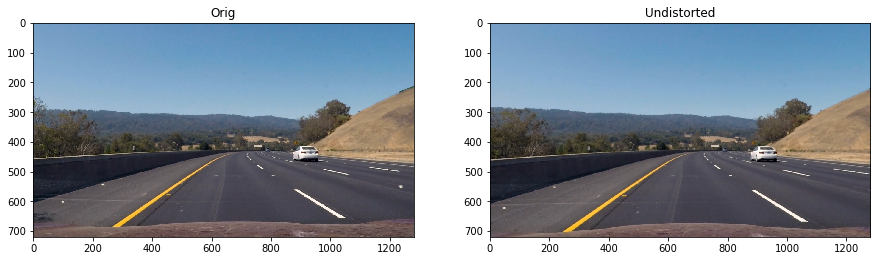

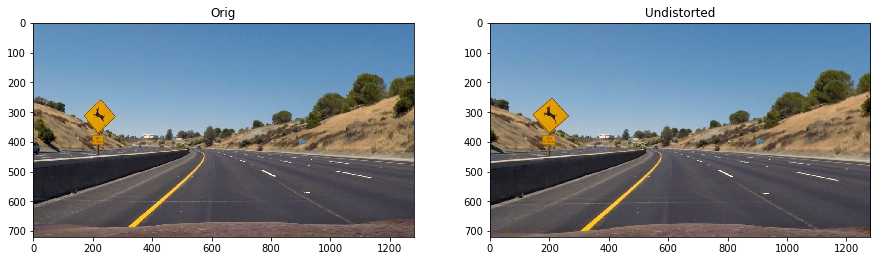

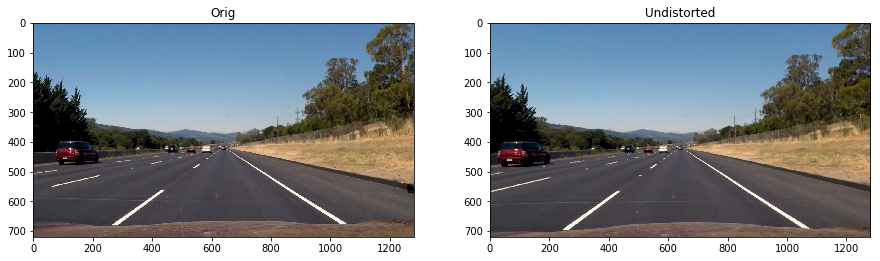

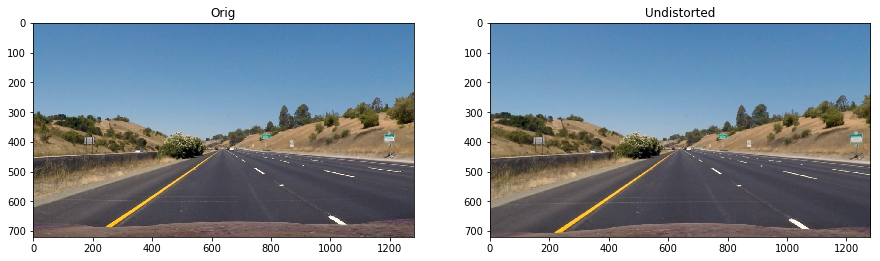

In [4]:
test_dir = glob.glob('test_images/*.jpg')
undistort_test_images = []
for fname in test_dir:
    test_img = mpimg.imread(fname)
    undistort_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    undistort_test_images.append(undistort_test_img)
    plt.figure(figsize=(15,15))
    plt.subplot(121, title='Orig')
    plt.imshow(test_img)
    plt.subplot(122, title='Undistorted')
    plt.imshow(undistort_test_img)

Let's try out thresholding for one of the test images.
* Try a couple methods
* Lab B filter for yellow stuff
* HLS L filter for white stuff

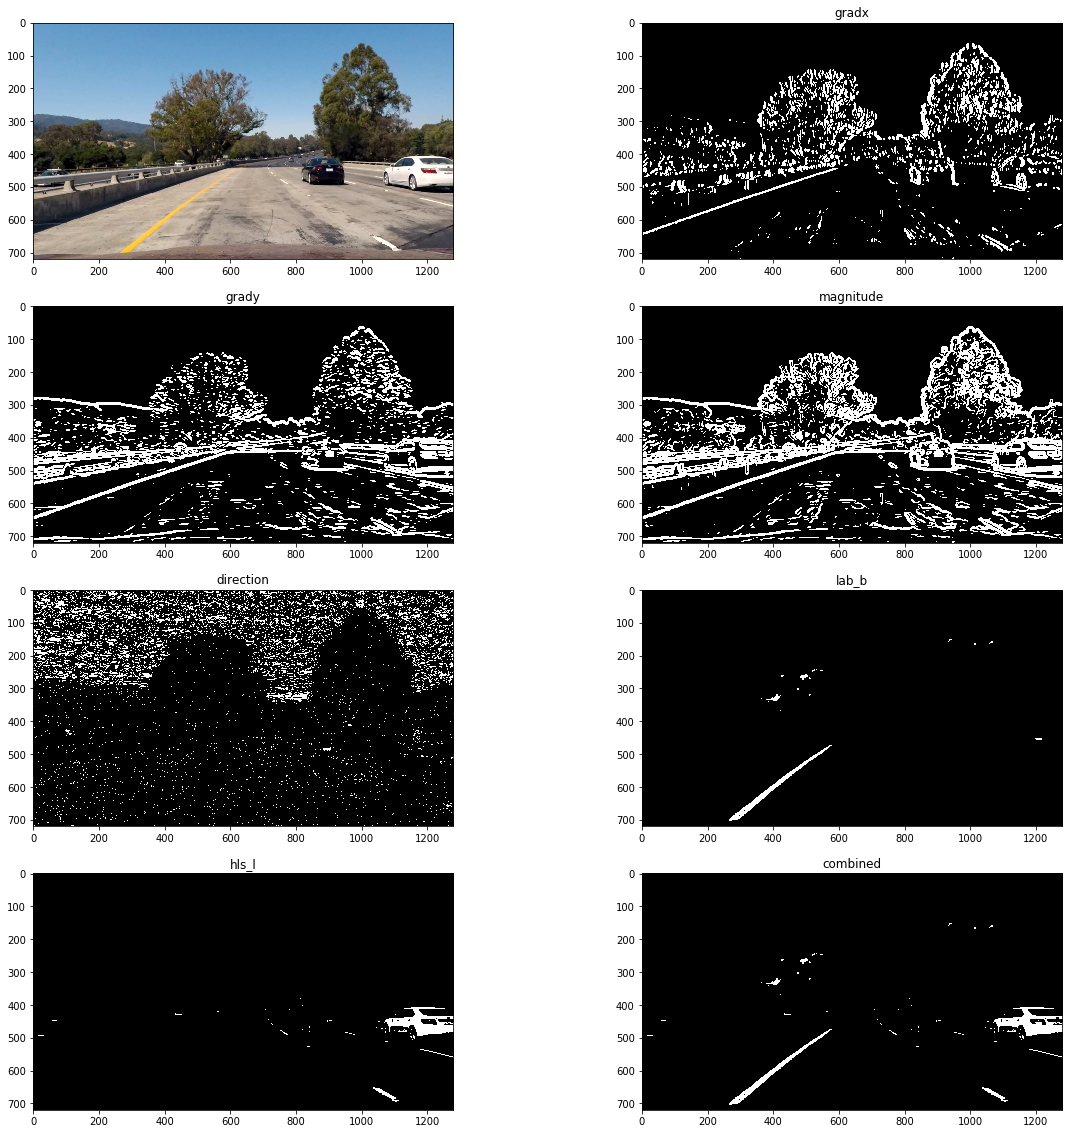

In [5]:
def image_thresholding(img, ksize = 25, sobel_thresh=(25, 255), dir_thresh=(0, 0.09), show=False):
    lab_l = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:, :, 0]
    lab_b = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:, :, 2]
    hls_l = (cv2.cvtColor(img, cv2.COLOR_RGB2HLS))[:, :, 1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(lab_l, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
    grady = abs_sobel_thresh(lab_l, orient='y', sobel_kernel=ksize, thresh=sobel_thresh)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=sobel_thresh)
    dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=dir_thresh)
    lab_b_binary = color_threshold(lab_b, thresh=(190, 255))
    hls_l_binary = color_threshold(hls_l, thresh=(220, 255))
    combined = np.zeros_like(gray)
    combined[(hls_l_binary == 1) | (lab_b_binary == 1)] = 1
    if show:
        plt.figure(figsize=(20, 20))
        plt.subplot(421)
        plt.imshow(img)
        plt.subplot(422, title='gradx')
        plt.imshow(gradx, cmap='gray')
        plt.subplot(423, title='grady')
        plt.imshow(grady, cmap='gray')
        plt.subplot(424, title='magnitude')
        plt.imshow(mag_binary, cmap='gray')
        plt.subplot(425, title='direction')
        plt.imshow(dir_binary, cmap='gray')
        plt.subplot(426, title='lab_b')
        plt.imshow(lab_b_binary, cmap='gray')
        plt.subplot(427, title='hls_l')
        plt.imshow(hls_l_binary, cmap='gray')
        plt.subplot(428, title='combined')
        plt.imshow(combined, cmap='gray')
    return combined
        
out = image_thresholding(undistort_test_images[3], show=True)

Go through the whole pipeline and identify the region of interest (black out the surroundings)

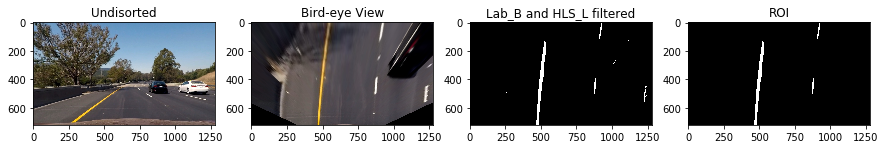

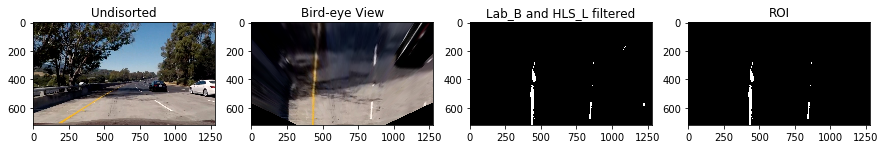

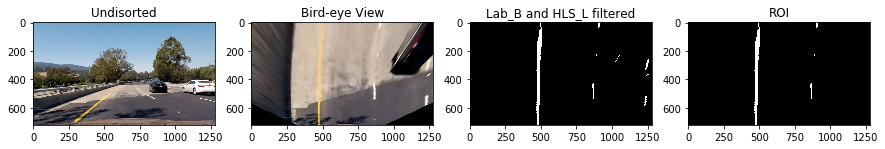

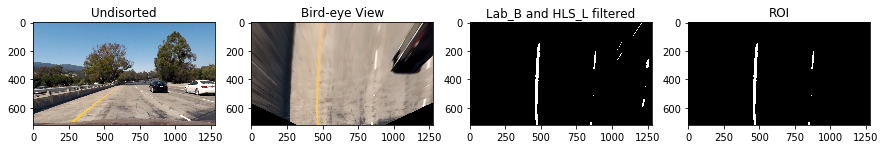

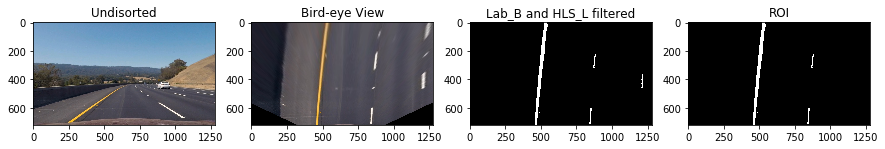

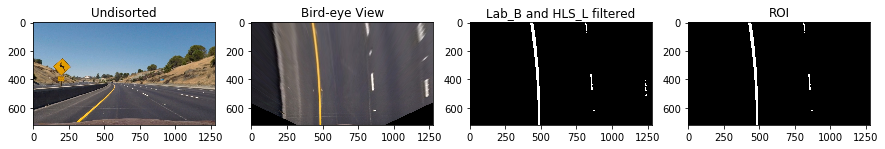

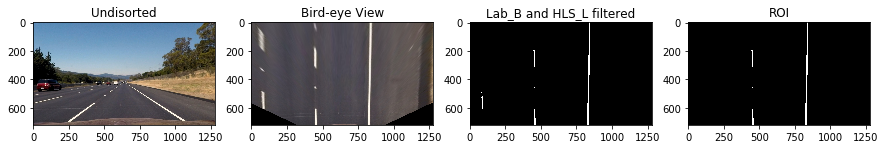

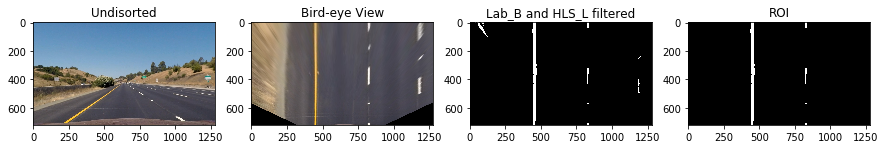

In [8]:
# Top left, top right, bottom right, bottom left. [ [], [], [], [] ]. (1280, 720)
corners = [(575,464), (707,464), (258,682), (1049,682)]
warped = []
M_inverse_cache = []
for src_img in undistort_test_images:  
    dst_img, M_inv = perspective_transform(src_img, mtx, dist, corners)
    thresholded = image_thresholding(dst_img)
    thresholded_roi = region_of_interest(thresholded, get_vertices(thresholded, bottom_width = 0.45, top_width = 0.45, height_prop = 1))
    warped.append(thresholded_roi)
    M_inverse_cache.append(M_inv)
    plt.figure(figsize=(15,15))
    plt.subplot(141, title='Undisorted')
    plt.imshow(src_img, cmap='gray')
    plt.subplot(142, title='Bird-eye View')
    plt.imshow(dst_img, cmap='gray')
    plt.subplot(143, title='Lab_B and HLS_L filtered')
    plt.imshow(thresholded, cmap='gray')
    plt.subplot(144, title='ROI')
    plt.imshow(thresholded_roi, cmap='gray')

In [9]:
def blind_search(warped, num_windows=12, margin=80, minpix=40):
    """ Perform blind search of left and right lanes.
    
    Args:
        warped: a binary image with a bird-eye view of the 2 lanes.
        num_windows: number of windows to search on the y-axis. Larger num_windows = less mooth lines.
        margin: 2*margin will be the width of the search window over the x-axis.
        minpix: threshold that determine if the next window needs to be shifted.
    
    Returns: 
        left_fit
        right_fit
        left_idx: indexes that can retrieve non-zero x and y coordinates of the left lanes
        right_idx: indexes that can retrieve non-zero x and y coordinates of the right lanes
        (windows, hist): (coordinates of the search windows, histogram) for diagonostic visualization
    """
    y, x = warped.shape[0], warped.shape[1]
    # Identify non-zero pixel coordnates. [row][col] = [y][x]
    nonzero_y, nonzero_x = np.nonzero(warped)
    left_idx = []
    right_idx = [] # Eventually I need these 2 index vectors to retrieve nonzero_y and x to draw a curve
    windows = []
    
    # Get a histogram. [Frequency, Bin/Edges/pixel-position on x]
    hist = np.sum(warped, axis=0)     
    midpoint = np.int(x//2)
    left_x_base = np.argmax(hist[:midpoint])
    right_x_base = np.argmax(hist[midpoint:]) + midpoint
    y_base = y # First window at the bottom
    
    # Define the windows. 
    window_height = np.int(y/num_windows)
    for _ in range(num_windows):
        left_lower_x = left_x_base - margin
        left_upper_x = left_x_base + margin
        right_lower_x = right_x_base - margin
        right_upper_x = right_x_base + margin
        lower_y = y_base - window_height
        upper_y = y_base 
        # print(lower_y, upper_y, left_lower_x, left_upper_x, right_lower_x, right_upper_x)
        windows.append((lower_y, upper_y, left_lower_x, left_upper_x, right_lower_x, right_upper_x))
        # Identify paired coordinates with non-zero pixel
        nonzero_left_idx = ((nonzero_x >= left_lower_x) & (nonzero_x < left_upper_x) & (nonzero_y >= lower_y) & (nonzero_y < upper_y)).nonzero()[0]
        nonzero_right_idx = ((nonzero_x >= right_lower_x) & (nonzero_x < right_upper_x) & (nonzero_y >= lower_y) & (nonzero_y < upper_y)).nonzero()[0]
        
        # print(len(nonzero_left_idx), len(nonzero_right_idx))
        # If the number of pairs > minpix threshold, fix a new left and right x_base
        if len(nonzero_left_idx) > minpix:
            left_x_base = np.mean(nonzero_x[nonzero_left_idx])
        if len(nonzero_right_idx) > minpix:
            right_x_base = np.mean(nonzero_x[nonzero_right_idx])

        # Iterate through the next window
        left_idx.append(nonzero_left_idx)
        right_idx.append(nonzero_right_idx)
        y_base = lower_y 
    
    # print(np.concatenate(left_idx).shape, np.concatenate(right_idx).shape)
    # Retrieve significant points to run a polyfit
    final_left_x = nonzero_x[np.concatenate(left_idx)] # There will be repetition of x-coors?
    final_left_y = nonzero_y[np.concatenate(left_idx)]
    final_right_x = nonzero_x[np.concatenate(right_idx)]
    final_right_y = nonzero_y[np.concatenate(right_idx)]
    
    left_fit, right_fit = None, None
    if len(final_left_x) > 0:
        left_fit = np.polyfit(final_left_y, final_left_x, 2) # x = f(y)
    if len(final_right_x) > 0:
        right_fit = np.polyfit(final_right_y, final_right_x, 2)
        
    return left_fit, right_fit, np.concatenate(left_idx), np.concatenate(right_idx), (windows, hist)
        
def guided_search(warped, prev_left_fit, prev_right_fit, margin=80):
    """ Perform guided search of left and right lanes. Given the left and right fits of the previous frame. 
    
    Args:
        warped
        prev_left_fit
        prev_right_fit
        margin: search within the f(x) +- margin for actual non-zero x coordinates
    
    Returns: 
        left_fit
        right_fit
        left_idx: indexes that can retrieve non-zero x and y coordinates of the left lanes
        right_idx: indexes that can retrieve non-zero x and y coordinates of the right lanes
    """
    y, x = warped.shape[0], warped.shape[1]
    # Identify non-zero pixel coordnates. [row][col] = [y][x]
    nonzero_y, nonzero_x = np.nonzero(warped)
    left_idx = []
    right_idx = [] # Eventually I need these 2 index vectors to retrieve nonzero_y and x to draw a curve
    
    # Use the previous fits to extrapolate the x_left and x_right
    x_hat_left = prev_left_fit[0] * (nonzero_y**2) + prev_left_fit[1] * (nonzero_y) + prev_left_fit[2]
    x_hat_right = prev_right_fit[0] * (nonzero_y**2) + prev_right_fit[1] * (nonzero_y) + prev_right_fit[2]
    
    # Search within the margin of predicted x_left and x_right to search for actual non-zero x. Then store indexes
    left_lower_x = x_hat_left - margin
    left_upper_x = x_hat_left + margin
    right_lower_x = x_hat_right - margin
    right_upper_x = x_hat_right + margin
    left_idx = ((nonzero_x >= left_lower_x) & (nonzero_x < left_upper_x)).nonzero()[0]
    right_idx = ((nonzero_x >= right_lower_x) & (nonzero_x < right_upper_x)).nonzero()[0]
    
    # Retrieve actual non-zero x and y using the indexes
    
    # Fit the curve for this frame
    final_left_x = nonzero_x[left_idx] # There will be repetition of x-coors?
    final_left_y = nonzero_y[left_idx]
    final_right_x = nonzero_x[right_idx]
    final_right_y = nonzero_y[right_idx]
    
    left_fit, right_fit = None, None
    if len(final_left_x) > 0:
        left_fit = np.polyfit(final_left_y, final_left_x, 2) # x = f(y)
    if len(final_right_x) > 0:
        right_fit = np.polyfit(final_right_y, final_right_x, 2)
        
    return left_fit, right_fit, left_idx, right_idx

def compute_curvature_and_center_dist(warped, left_fit, right_fit, left_idx, right_idx, ym_per_pix=3.048/100, xm_per_pix=3.7/378):
    """Compute curvature of the lane and how far off the car position from the center lane
    
    Args:
        ym_per_pix = 3.048/100: meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
        xm_per_pix = 3.7/378: meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    Returns:
        left_curverad: left-lane curve radius
        right_curverad: right-lane curve radius
        center_dist: distance from the center position between 2 lanes
    """
    y, x = warped.shape[0], warped.shape[1]
    nonzero_y, nonzero_x = warped.nonzero()
    left_curverad, right_curverad, center_dist = 0, 0, 0
    
    # Get the curve coordinates y, f(y) using fits in the pixel world
    left_x = nonzero_x[left_idx]
    left_y = nonzero_y[left_idx]
    right_x = nonzero_x[right_idx]
    right_y = nonzero_y[right_idx]
    
    # Scale the coordinates y, f(y) in real world to compute coefficients of the polyfit
    # Note the condition. To catch whenever no lane is detected
    if len(left_x) > 0 and len(right_x) > 0: 
        left_fit_real = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
        right_fit_real = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
        A_left, B_left, C_left = left_fit_real
        A_right, B_right, C_right = right_fit_real
    
        # Apply curvature formula. y = bottom of image = 780
        left_curverad = (1 + (2*A_left*y*ym_per_pix + B_left)**2)**1.5 / np.absolute(2*A_left)
        right_curverad = (1 + (2*A_right*y*ym_per_pix + B_right)**2)**1.5 / np.absolute(2*A_right)
    
        # Compute center of the lane in pixel world
        car_position = x/2
        left_x_hat = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2] # Use y because just want the x-coor at the bottom
        right_x_hat = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        midlane_position = (right_x_hat + left_x_hat)/2
        center_dist = (car_position - midlane_position)*xm_per_pix

    return left_curverad, right_curverad, center_dist

def draw_lane(orig, warped, left_fit, right_fit, curv_rad, center_dist, M_inverse):
    """
    warped: binary image on which the lanes are drawn
    Use M_inverse to obtain unwarped and add data on top
    add_weighted(orig, unwarped) to get the lanes on the original (undistort) image 
    """
    new_img = orig.copy()
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Return the orig frame if no lane is found
    if len(left_fit) == 0 or len(right_fit) == 0:
        return new_img
    
    # Draw the 2 lane on warped, have to use ploty
    h, w, _ = orig.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Add weighted with the binary-image warped
    unwarped = cv2.warpPerspective(color_warp, M_inverse, (w, h)) 
    drawn = cv2.addWeighted(new_img, 1, unwarped, 0.5, 0)
    
    # Add data
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format((curv_rad[0] + curv_rad[1])/2) + 'm'
    cv2.putText(drawn, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(drawn, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return drawn

Let's test the blind search function

Radius of curvature: Left = 867.478 meters, Right = 551.077 meters. Distance from center = -0.283 meters


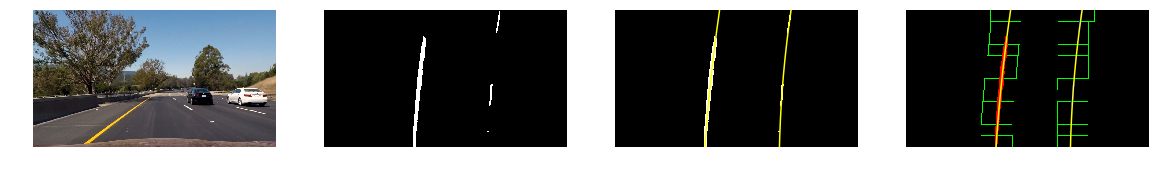

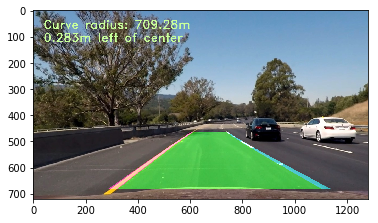

Radius of curvature: Left = 375.594 meters, Right = 2425.726 meters. Distance from center = 0.005 meters


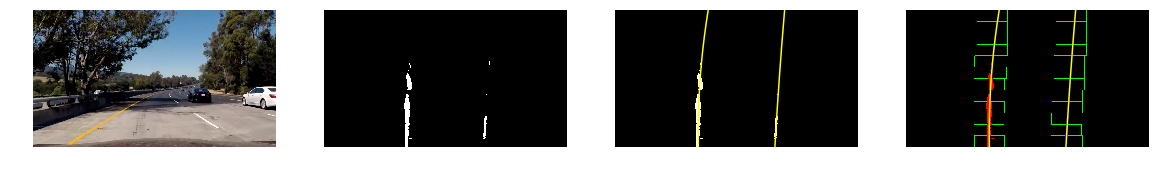

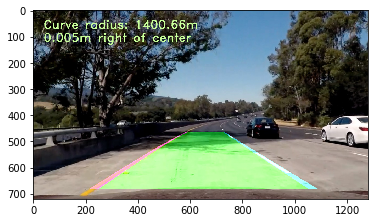

Radius of curvature: Left = 876.068 meters, Right = 417.147 meters. Distance from center = -0.317 meters


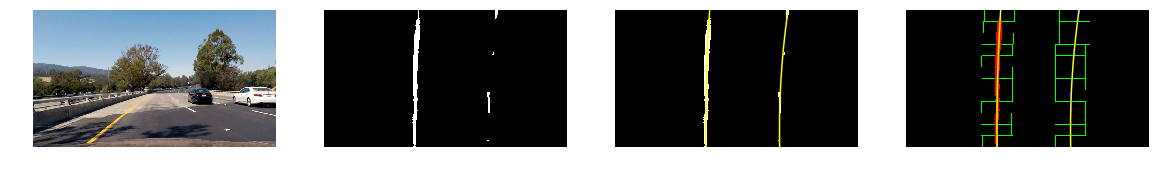

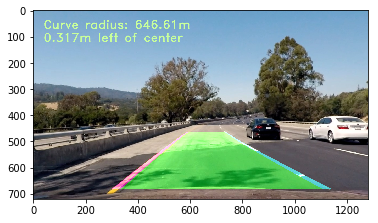

Radius of curvature: Left = 480.155 meters, Right = 1999.676 meters. Distance from center = -0.188 meters


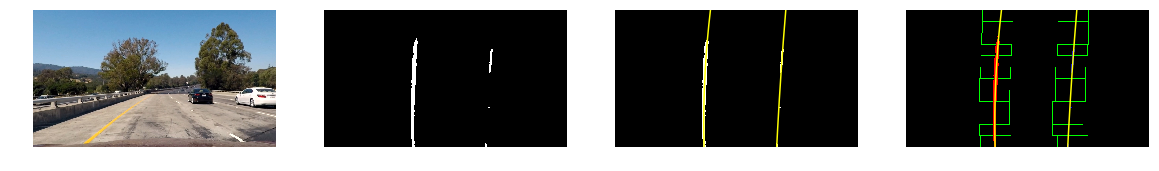

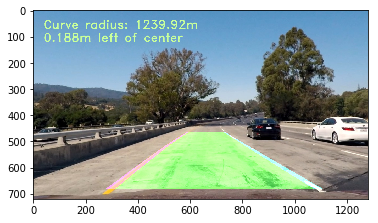

Radius of curvature: Left = 1200.408 meters, Right = 581.017 meters. Distance from center = -0.136 meters


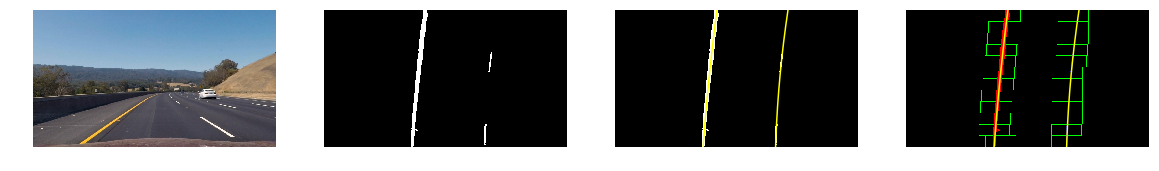

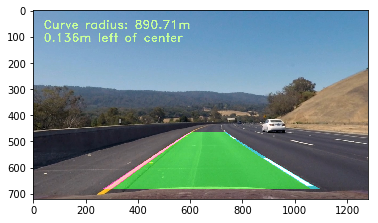

Radius of curvature: Left = 454.425 meters, Right = 1260.242 meters. Distance from center = -0.399 meters


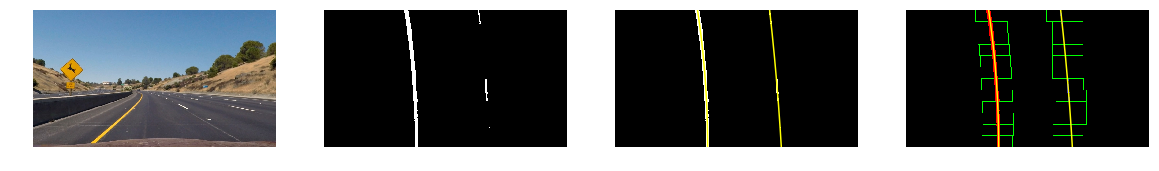

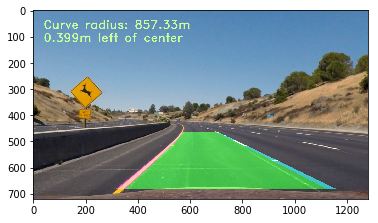

Radius of curvature: Left = 2249.631 meters, Right = 10094.873 meters. Distance from center = -0.028 meters


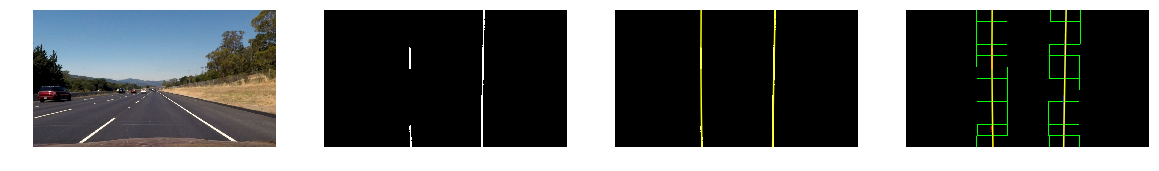

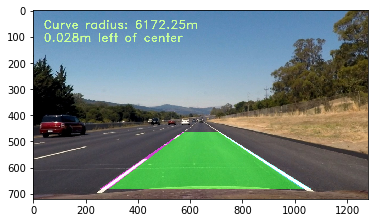

Radius of curvature: Left = 1751.744 meters, Right = 10352.496 meters. Distance from center = 0.002 meters


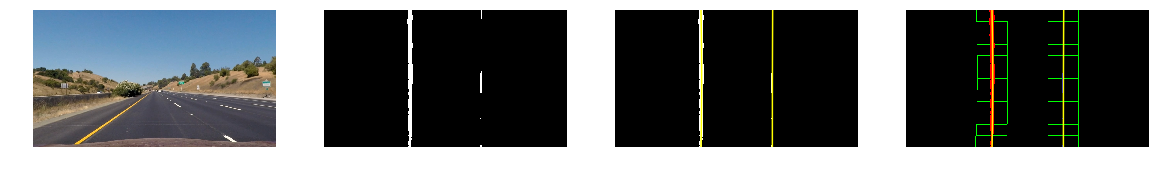

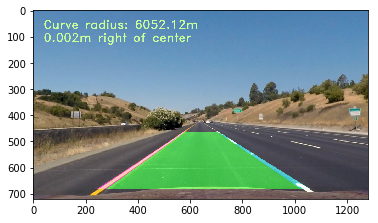

In [10]:
for idx, exampleImg_bin in enumerate(warped):
    exampleImg = undistort_test_images[idx]
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = blind_search(exampleImg_bin)
    left_curverad, right_curverad, center_dist = compute_curvature_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    print("Radius of curvature: Left = {:.3f} meters, Right = {:.3f} meters. Distance from center = {:.3f} meters".format(left_curverad, right_curverad, center_dist))
    
    y = exampleImg.shape[0]
    left_fit_x_int = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fit_x_int = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    for rect in rectangles:
        rect = [int(i) for i in rect]
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
        
    drawn = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, (left_curverad, right_curverad), center_dist, M_inverse_cache[idx])
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(exampleImg)
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(exampleImg_bin, cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(exampleImg_bin, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.axis('off')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    plt.figure()
    plt.imshow(drawn)
    plt.show()

Assume frame 2 comes after frame 1. Let's test the guided search function.

* The green polygon is drawn by the previous fits 
* The yellow line is the current fit

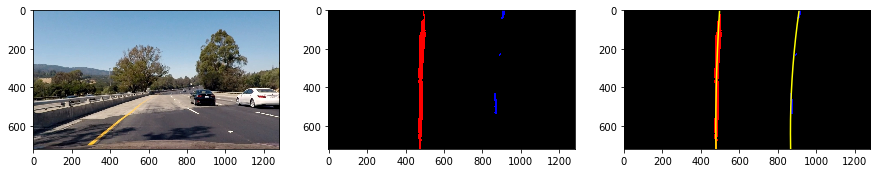

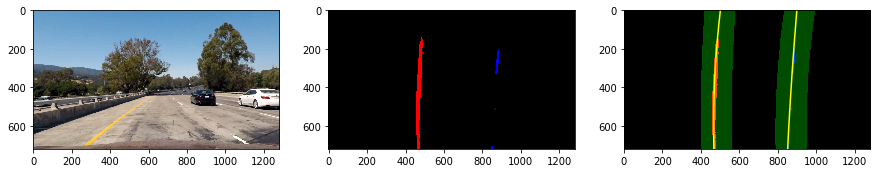

In [13]:
margin = 80
left_fit1, right_fit1, left_lane_inds1, right_lane_inds1, _ = blind_search(warped[2])
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = guided_search(warped[3], left_fit, right_fit, margin=margin)

# Generate x and y values for plotting
ploty = np.linspace(0, y-1, num=y)
left_fitx1 = left_fit1[0]*ploty**2 + left_fit1[1]*ploty + left_fit1[2]
right_fitx1 = right_fit1[0]*ploty**2 + right_fit1[1]*ploty + right_fit1[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img1 = np.uint8(np.dstack((warped[2], warped[2], warped[2]))*255)
out_img2 = np.uint8(np.dstack((warped[3], warped[3], warped[3]))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzeroy_1, nonzerox_1 = warped[2].nonzero()
nonzeroy_2, nonzerox_2 = warped[3].nonzero()
out_img1[nonzeroy_1[left_lane_inds1], nonzerox_1[left_lane_inds1]] = [255, 0, 0]
out_img1[nonzeroy_1[right_lane_inds1], nonzerox_1[right_lane_inds1]] = [0, 0, 255]
out_img2[nonzeroy_2[left_lane_inds2], nonzerox_2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy_2[right_lane_inds2], nonzerox_2[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx1-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx1+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx1-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx1+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0) # Blend between binary and 3-channel images

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(undistort_test_images[2])
plt.subplot(132)
plt.imshow(out_img1, cmap='gray')
plt.subplot(133)
plt.imshow(out_img1, cmap='gray')
plt.plot(left_fitx1, ploty, color='yellow')
plt.plot(right_fitx1, ploty, color='yellow')

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(undistort_test_images[3])
plt.subplot(132)
plt.imshow(out_img2, cmap='gray')
plt.subplot(133)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')

## Finalize the pipeline

In [48]:
def preprocess_image(img, corners=[(575,464), (707,464), (258,682), (1049,682)]):
    y, x, _ = img.shape
    # Get the calibration matrices
    calib = pickle.load(open("camera_cal/wide_calib_pickle.p", "rb"))
    mtx, dist = calib["mtx"], calib["dist"]
    # Undistort
    img_undistort = undistort(img, mtx, dist)
    # Perspective transform
    warped, M_inverse = perspective_transform(img_undistort, mtx, dist, corners=corners)
    # Thresholding the bird-eye view
    warped_thresholded = image_thresholding(warped)
    warped_thresholded_roi = region_of_interest(warped_thresholded, get_vertices(warped_thresholded, bottom_width = 0.45, top_width = 0.45, height_prop = 1))
    plt.figure()
    plt.imshow(warped_thresholded_roi, cmap='gray')
    plt.show
    return warped_thresholded_roi, M_inverse

In [49]:
class Line():
    """
    2 central objects that we are dealing with left = Line() and right = Line()
    For each line we have:
    - detected: determine if we should perform blind search or guided search from previous frame
    - best_fit: storing the best fit so far, which is the average of the history_fit. Benchmark to add new_fit
    - history_fit: storing valid fits 
    - look_back: number of previous frames accounted for smoothing
    """
    def __init__(self, look_back=10):
        self.detected = False
        self.best_fit = None
        self.history_fit = []
        self.look_back = look_back
        self.inds = None
        self.diffs = np.array([0,0,0], dtype='float') # Coefficient differences
        
    def check_fit(self, fit1, fit2):
        """
        Compare if fit2 coefficients are in the proximity of fit1
        """
        if len(fit2) != len(fit1):
            return False
        elif abs(fit2[0] - fit1[0]) > 0.001 or abs(fit2[1] - fit2[1]) > 1.0 or abs(fit2[2] - fit1[2]) > 100:
            return False
        else:
            return True
            
    def add_fit(self, new_fit, inds):
        self.inds = inds
        if new_fit is not None:
            # If we have an existing best_fit. Check if new_fit in the proximity. 
            # If in proximity, we add to history 
            # and compute new best_fit by averaging the coefficients of the fits of previous look_back frames. 
            if self.best_fit is not None:
                self.diffs = np.absolute(new_fit-self.best_fit)
                if self.check_fit(self.best_fit, new_fit):
                    self.history_fit.append(new_fit)
                    # Discard history fits that are further than look_back frames. 
                    if len(self.history_fit) > self.look_back:
                        self.history_fit = self.history_fit[len(self.history_fit)-self.look_back:]
                    self.best_fit = np.average(self.history_fit, axis=0)
                    self.detected = True # Guided search for next frame.
                else:
                    self.detected = False # If not in proximity, blind search the next frame.
            # If there is no existing best_fit. Assign the valid new_fit as the best_fit and add to history.
            else:
                self.history_fit.append(new_fit)
                self.best_fit = new_fit
                self.detected = True
                
        # If it is not a valid fit (2 lines are separated by a large margin, for example)
        # Do a guided search for the next frame. But store the average of previous fits (excluding the most recent) as 
        # a benchmark.
        else:
            self.detected = False # Blind search the next frame
            if len(self.history_fit) > 0:
                # Remove the most recent fit because that might mess it up.
                _ = self.history_fit.pop()
                if len(self.history_fit) > 0:
                    self.best_fit = np.average(self.history_fit, axis=0) # Average the remaining 

For every video frame, this function will run

In [50]:
left_line = Line()
right_line = Line()

def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

def process_image(img, diagnostic_view=True):
    input_img = img.copy()
    binary_img, M_inverse = preprocess_image(input_img) # Already thresholding for white and yellow lanes
    
    # Guided search if best_fits have been found
    if left_line.detected and right_line.detected: 
        left_fit, right_fit, left_idx, right_idx = guided_search(binary_img, left_line.best_fit, right_line.best_fit)
    else:
        left_fit, right_fit, left_idx, right_idx, vis = blind_search(binary_img)
        
    # Invalidate left and right fit if the margin is too big. By checking the bottom points
    if left_fit is not None and right_fit is not None:
        y = binary_img.shape[0]
        left_x_hat = left_fit[0]*(y**2) + left_fit[1]*y + left_fit[2]
        right_x_hat = right_fit[0]*(y**2) + right_fit[1]*y + right_fit[2]
        if np.absolute(350 - np.absolute(left_x_hat - right_x_hat)) > 100:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit, left_idx)
    right_line.add_fit(right_fit, right_idx)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        # If best_fit for left and right is found, draw the lanes and related stats
        curv_rad_left, curv_rad_right, center_dist = compute_curvature_and_center_dist(binary_img, left_line.best_fit, right_line.best_fit, left_idx, right_idx, ym_per_pix=3.048/100, xm_per_pix=3.7/378)
        out_img = draw_lane(input_img, binary_img, left_line.best_fit, right_line.best_fit, (curv_rad_left, curv_rad_right), center_dist, M_inverse)
    else:
        # If best_fit can't be found, return the orig image, no lanes drawn
        out_img = input_img
    
    if diagnostic_view:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)

        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(out_img,(640,360))

        # binary overhead view (top right)
        binary_img = np.dstack((binary_img*255, binary_img*255, binary_img*255))
        resized_img_bin = cv2.resize(binary_img,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin

        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(binary_img)
        for i, fit in enumerate(left_line.history_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(right_line.history_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, left_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, right_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))

        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if left_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(left_fit[0]) + \
                                    ' {:0.6f}'.format(left_fit[1]) + \
                                    ' {:0.6f}'.format(left_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if right_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(right_fit[0]) + \
                                    ' {:0.6f}'.format(right_fit[1]) + \
                                    ' {:0.6f}'.format(right_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(left_line.best_fit[0]) + \
                                ' {:0.6f}'.format(left_line.best_fit[1]) + \
                                ' {:0.6f}'.format(left_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(right_line.best_fit[0]) + \
                                ' {:0.6f}'.format(right_line.best_fit[1]) + \
                                ' {:0.6f}'.format(right_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(left_line.diffs[0]) + \
                             ' {:0.6f}'.format(left_line.diffs[1]) + \
                             ' {:0.6f}'.format(left_line.diffs[2])
        if left_line.diffs[0] > 0.001 or left_line.diffs[1] > 1.0 or left_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(right_line.diffs[0]) + \
                             ' {:0.6f}'.format(right_line.diffs[1]) + \
                             ' {:0.6f}'.format(right_line.diffs[2])
        if right_line.diffs[0] > 0.001 or right_line.diffs[1] > 1.0 or right_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(left_line.history_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(right_line.history_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        out_img = diag_img
        
    return out_img

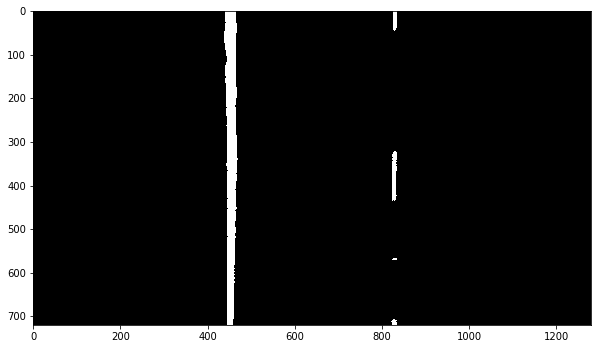

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(warped[-1], cmap='gray')
plt.show()

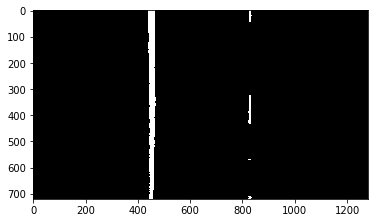

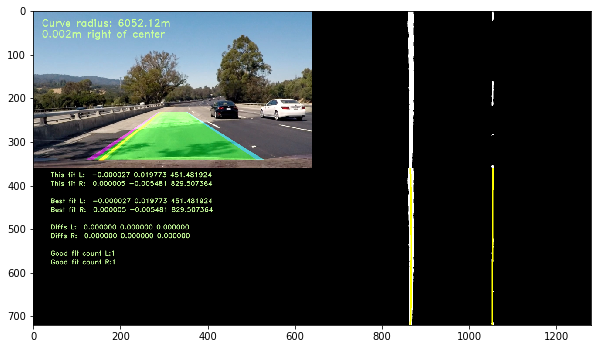

In [51]:
k1 = process_image(mpimg.imread(test_dir[2]))
plt.figure(figsize=(10,10))
plt.imshow(k1)
plt.show()

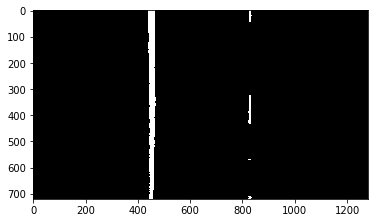

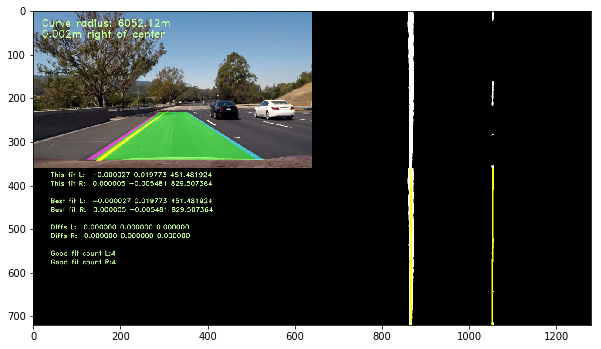

In [54]:
k2 = process_image(mpimg.imread(test_dir[0]))
plt.figure(figsize=(10,10))
plt.imshow(k2)
plt.show()

In [17]:
left_line = Line()
right_line = Line()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(22,28)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|█████████▉| 150/151 [01:08<00:00,  2.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 19s, sys: 11.7 s, total: 1min 30s
Wall time: 1min 9s


In [18]:
HTML("""<video width="960" height="540" controls> <source src="{0}"></video>""".format(video_output1))